In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 143kB 9.1MB/s 


In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
class MyDataset(Dataset):
  def __init__(self, size=5000, dim=40, random_offset=0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset

  def __getitem__(self, index):
      if index >= len(self):
          raise IndexError("{} index out of range".format(self.__class__.__name__))

      rng_state = torch.get_rng_state()
      torch.manual_seed(index + self.random_offset)

      while True:
        img = torch.zeros(self.dim, self.dim)
        dx = torch.randint(-10,10,(1,),dtype=torch.float)
        dy = torch.randint(-10,10,(1,),dtype=torch.float)
        c = torch.randint(-20,20,(1,), dtype=torch.float)

        params = torch.cat((dy/dx, c))
        xy = torch.randint(0,img.shape[1], (20, 2), dtype=torch.float)
        xy[:,1] = xy[:,0] * params[0] + params[1]

        xy.round_()
        xy = xy[ xy[:,1] > 0 ]
        xy = xy[ xy[:,1] < self.dim ]
        xy = xy[ xy[:,0] < self.dim ]

        for i in range(xy.shape[0]):
          x, y = xy[i][0], self.dim - xy[i][1]
          img[int(y), int(x)]=1
        if img.sum() > 2:
          break

      torch.set_rng_state(rng_state)
      return img.unsqueeze(0), params

  def __len__(self):
      return self.size




torch.Size([1, 40, 40])


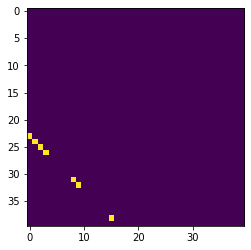

In [5]:
train_data = MyDataset()
val_data = MyDataset(size=500, random_offset=33333)
test_data = MyDataset(size=500, random_offset=99999)
print(train_data[0][0].size())
plt.imshow(train_data[0][0].squeeze())

trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)


In [0]:
def get_metrics(results):

  frame = pd.DataFrame.from_records(results)
  train_loss_r = frame.loss.to_numpy()
  train_mse_r = frame.mse.to_numpy()
  val_loss_r = frame.val_loss.to_numpy()
  val_mse_r = frame.val_mse.to_numpy()

  return  train_loss_r, train_mse_r, val_loss_r, val_mse_r

In [0]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1, stride=1)
        self.fc1 = nn.Linear(48 * 40**2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [8]:
# build the model
model = BaselineCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader, val_generator=valloader)
history = trial.run(epochs=100)

train_loss: 0.680574357509613, train_mse: 0.6860289573669434, val_loss:17.156063079833984, val_mse: 17.083593368530273



Test: {'test_loss': 17.088359832763672, 'test_mse': 17.211498260498047}


Text(0, 0.5, 'Score')

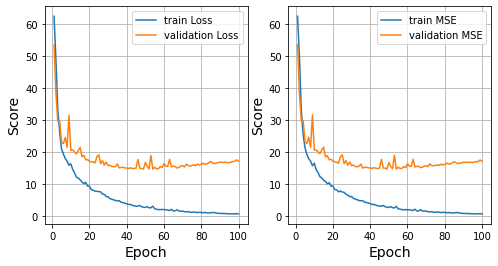

In [9]:
train_loss_r, train_mse_r, val_loss_r, val_mse_r = get_metrics(history)
print(f"train_loss: {train_loss_r[-1]}, train_mse: {train_mse_r[-1]}, val_loss:{val_loss_r[-1]}, val_mse: {val_mse_r[-1]}")
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(f"Test: {results}")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
x = np.linspace(1,100,100)
ax[0].plot(x, train_loss_r, label="train Loss")
ax[0].plot(x, val_loss_r, label="validation Loss")
ax[0].grid(True)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].legend()
ax[0].set_ylabel("Score", fontsize=14)

ax[1].plot(x, train_mse_r, label="train MSE")
ax[1].plot(x, val_mse_r, label="validation MSE")
ax[1].grid(True)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].legend()
ax[1].set_ylabel("Score", fontsize=14)

In [0]:
class GlobalPoolingCNN(nn.Module):
    def __init__(self):
        super(GlobalPoolingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1, stride=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1, stride=1)
        self.fc1 = nn.Linear(48, 128)
        self.globalMaxPool = nn.AdaptiveMaxPool2d(1)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.globalMaxPool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out




In [14]:
# build the model
model = GlobalPoolingCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader, val_generator=valloader)
history = trial.run(epochs=100)

train_loss: 13.050997734069824, train_mse: 13.078619956970215, val_loss:11.556587219238281, val_mse: 11.526180267333984


Text(0, 0.5, 'Score')

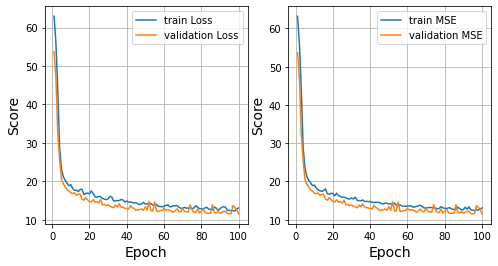

In [15]:
train_loss_r, train_mse_r, val_loss_r, val_mse_r = get_metrics(history)
print(f"train_loss: {train_loss_r[-1]}, train_mse: {train_mse_r[-1]}, val_loss:{val_loss_r[-1]}, val_mse: {val_mse_r[-1]}")
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
x = np.linspace(1,100,100)
ax[0].plot(x, train_loss_r, label="train Loss")
ax[0].plot(x, val_loss_r, label="validation Loss")
ax[0].grid(True)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].legend()
ax[0].set_ylabel("Score", fontsize=14)

ax[1].plot(x, train_mse_r, label="train MSE")
ax[1].plot(x, val_mse_r, label="validation MSE")
ax[1].grid(True)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].legend()
ax[1].set_ylabel("Score", fontsize=14)

In [0]:
class GlobalPoolingCNN2(nn.Module):
    def __init__(self):
        super(GlobalPoolingCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), padding=1, stride=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1, stride=1)
        self.fc1 = nn.Linear(48 * 1**2, 128)
        self.fc2 = nn.Linear(128, 2)
            
    def forward(self, x):
        idxx = torch.repeat_interleave(
            torch.arange(-20,20, dtype=torch.float).unsqueeze(0)/ 40.0,
            repeats=40, dim = 0).to(x.device)
        idxy = idxx.clone().t()
        idx = torch.stack([idxx, idxy]).unsqueeze(0)
        idx = torch.repeat_interleave(idx, repeats=x.shape[0], dim=0)
        x = torch.cat([x, idx], dim=1)
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = nn.AdaptiveMaxPool2d(1)(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [17]:
# build the model
model = GlobalPoolingCNN2()

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, test_generator=testloader, val_generator=valloader)
history = trial.run(epochs=100)

In [0]:
from PIL import Image
import torchvision

transform = torchvision.transforms.ToTensor()
for x in trainloader:
  im = x[0]
  print()
  break

def hook_function(module, grad_in, grad_out):
    for i in range(grad_out.shape[1]):
        conv_output = grad_out.data[0, i]
        plt.subplot(5, int(1+grad_out.shape[1]/5), i+1)
        plt.imshow(conv_output, cmap=plt.get_cmap('gray'))
        
hook = model.conv2.register_forward_hook(hook_function) # register the hook
model(im) # forward pass
hook.remove() #Tidy up

RuntimeError: ignored

train_loss: 1.097724437713623, train_mse: 1.1181668043136597, val_loss:1.2197328805923462, val_mse: 1.213401436805725


Text(0, 0.5, 'Score')

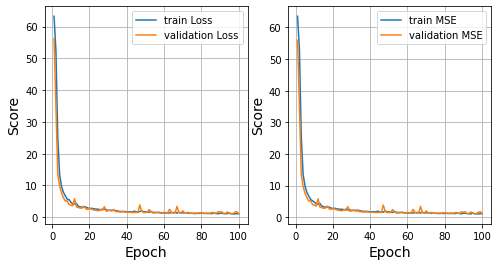

In [18]:
train_loss_r, train_mse_r, val_loss_r, val_mse_r = get_metrics(history)
print(f"train_loss: {train_loss_r[-1]}, train_mse: {train_mse_r[-1]}, val_loss:{val_loss_r[-1]}, val_mse: {val_mse_r[-1]}")
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
x = np.linspace(1,100,100)
ax[0].plot(x, train_loss_r, label="train Loss")
ax[0].plot(x, val_loss_r, label="validation Loss")
ax[0].grid(True)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].legend()
ax[0].set_ylabel("Score", fontsize=14)

ax[1].plot(x, train_mse_r, label="train MSE")
ax[1].plot(x, val_mse_r, label="validation MSE")
ax[1].grid(True)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].legend()
ax[1].set_ylabel("Score", fontsize=14)

In [0]:
torch.arange(-20,20, dtype=torch.float).unsqueeze(0)/ 40.0

tensor([[-0.5000, -0.4750, -0.4500, -0.4250, -0.4000, -0.3750, -0.3500, -0.3250,
         -0.3000, -0.2750, -0.2500, -0.2250, -0.2000, -0.1750, -0.1500, -0.1250,
         -0.1000, -0.0750, -0.0500, -0.0250,  0.0000,  0.0250,  0.0500,  0.0750,
          0.1000,  0.1250,  0.1500,  0.1750,  0.2000,  0.2250,  0.2500,  0.2750,
          0.3000,  0.3250,  0.3500,  0.3750,  0.4000,  0.4250,  0.4500,  0.4750]])

In [0]:
  idxx = torch.repeat_interleave(
            torch.arange(-20,20, dtype=torch.float).unsqueeze(0)/ 40.0,
            repeats=40, dim = 0)
  print(idxx.size())
  idxx

torch.Size([40, 40])


tensor([[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        ...,
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
        [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]])

tensor([[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
        [-0.4750, -0.4750, -0.4750,  ..., -0.4750, -0.4750, -0.4750],
        [-0.4500, -0.4500, -0.4500,  ..., -0.4500, -0.4500, -0.4500],
        ...,
        [ 0.4250,  0.4250,  0.4250,  ...,  0.4250,  0.4250,  0.4250],
        [ 0.4500,  0.4500,  0.4500,  ...,  0.4500,  0.4500,  0.4500],
        [ 0.4750,  0.4750,  0.4750,  ...,  0.4750,  0.4750,  0.4750]])
tensor([[[[-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          ...,
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750],
          [-0.5000, -0.4750, -0.4500,  ...,  0.4250,  0.4500,  0.4750]],

         [[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.4750, -0.4750, -0.4750,  ..., -

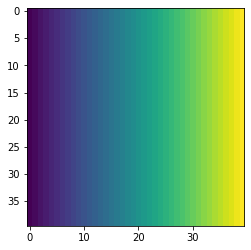

In [0]:
idxy = idxx.clone().t()
print(idxy)
idx = torch.stack([idxx, idxy]).unsqueeze(0)
plt.imshow(idxx)
print(idx)
print(idx.size())
idx = torch.repeat_interleave(idx, repeats=120, dim=0)
print(idx)
print(idx.size())
#x = torch.cat([x, idx], dim=1)